In [1]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as cx

import matplotlib.pyplot as plt

In [2]:
edges = pd.read_csv("https://raw.githubusercontent.com/rafaelprietocuriel/AfricanUrbanNetwork/main/AfricaNetworkEdges.csv")
nodes = pd.read_csv("https://raw.githubusercontent.com/rafaelprietocuriel/AfricanUrbanNetwork/main/AfricaNetworkNodes.csv", encoding='unicode_escape', engine ='python')
risks = pd.read_csv("../data/EDIndex20221202.csv")

In [3]:
edges = edges.merge(risks[['from', 'to', 'index']], left_on=['from', 'to'], right_on=['from', 'to'], how='left')
edges.head()

,from,to,l,h,time,timeU,timeUCB,border,index
0,8211,2333,4.294382,motorway,2.576629,80.447015,80.447015,0,40.518729
1,8211,1000559,1.771612,motorway,1.062967,15.148263,15.148263,0,34.595838
2,8211,1000567,5.414267,motorway,3.248560,17.333856,17.333856,0,29.757905
3,8211,5425,0.798800,primary,1.198201,21.555303,21.555303,0,32.325426
4,8211,1054396,50.646909,primary,75.970364,90.055660,90.055660,0,21.123829


In [4]:
G = nx.from_pandas_edgelist(edges, source='from', target='to', edge_attr = ['l', 'time', 'timeU', 'timeUCB', 'index'])

In [5]:
nx.set_node_attributes(G, nodes.set_index('Agglomeration_ID').to_dict('index'))

In [6]:
edges['risk'] = edges['index']

In [7]:
lengths = []
components = list()

for i in np.arange(0, 100):
    G_ = G.copy()
    _ = [G_.remove_edge(u, v) for u, v, d in G.edges(data=True) if d['index'] > i]
    
    labels = pd.DataFrame({u: i for i, n in enumerate(sorted(nx.connected_components(G_), key=len, reverse=True)) for u in n}, index=['component']).T
    labels['threshold'] = i
    labels['gcc'] = len(max(nx.connected_components(G_), key=len))
    
    lengths.append(len(max(nx.connected_components(G_), key=len)))
    components.append(labels)
    
components = pd.concat(components)
components.head()

,component,threshold,gcc
8211,0,0,1
2333,1,0,1
1000559,2,0,1
1000567,3,0,1
5425,4,0,1


In [8]:
def clean_components(dataframe, nodes=nodes, edges=edges):
    edges_copy = edges.copy()
    nodes_copy = nodes.copy()

    components_copy = dataframe[dataframe.threshold.isin(np.arange(0, 100))].merge(nodes_copy,
                                                                                   left_index=True, right_on='Agglomeration_ID', how='left')


    components_copy['aggnm'] = components_copy['agglosName']
    components_copy['pop15'] = components_copy['Pop2015']
    components_copy['thrno'] = components_copy['threshold']
    components_copy['thrid'] = components_copy['threshold'].astype(int).astype(str).str.pad(fillchar="0", side='left', width=7)
    components_copy['comid'] = components_copy['component'].astype(str).str.pad(fillchar="0", side='left', width=7)
    components_copy['aggid'] = components_copy['Agglomeration_ID'].astype(str).str.pad(fillchar="0", side='left', width=7)

    components_copy = components_copy[['aggnm', 'pop15', 'thrno', 'thrid', 'comid', 'aggid', 'gcc', 'Agglomeration_ID']]

    biggest = components_copy.sort_values('pop15', ascending=False).groupby(['thrid', 'comid'], as_index=False).first()
    biggest['biggest_rank'] = biggest.pop15.rank(ascending=False, method='dense')
    n_comps = components_copy[components_copy['aggnm']!='road'].groupby(['thrid', 'comid'], as_index=False).agg({'pop15': ['count', 'sum']})
    n_comps.columns = [''.join(x) for x in n_comps.columns]
    
    components_copy = components_copy.merge(biggest[['thrid', 'comid', 'aggnm', 'pop15', 'biggest_rank']].rename(columns={'aggnm': 'biggest_city', 'pop15': 'biggest_pop'}), 
                                            left_on=['thrid', 'comid'], 
                                            right_on=['thrid', 'comid'], 
                                            how='left').merge(n_comps, 
                                                              left_on=['thrid', 'comid'], 
                                                              right_on=['thrid', 'comid'], 
                                                              how='left').sort_values('pop15count', ascending=False)
    
    return components_copy

In [9]:
components = clean_components(components)

In [10]:
trends = components[['thrno', 'gcc']].groupby('thrno', as_index=False).first()
trends['lag'] = trends.gcc.shift(1)
trends['change'] =  trends.gcc - trends.lag
changepoints = np.append([10], np.append(trends.nlargest(6, 'change').sort_values('thrno').thrno.to_numpy(), 1240))

In [11]:
from colorcet import palette
from matplotlib import colors
pal = np.tile(palette['glasbey_light'], len(nodes) // len(palette['glasbey_light']))
pal = colors.ListedColormap(pal)

In [12]:
africa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = africa[africa['continent']=="Africa"]
africa = africa[africa['iso_a3']!= 'MDG']

In [139]:
def get_color(x):
    # rank the components by count where last place is just the next number in the sequence
    comp_pal = x.groupby(['thrid', 'comid'], as_index=False).agg({'Agglomeration_ID': 'count', 'pop15': 'sum'}).sort_values('pop15', ascending=False)
    comp_pal['rank'] = comp_pal['Agglomeration_ID'].rank(ascending=False, method='min')

    # assign the highest rank #7c7c7c, all the lowest rank #00cff9, the rest shuffle from np.random.choice(cc.palette['glasbey_light'], len(np.unique(region)))
    comp_pal['color'] = np.where(comp_pal['rank']==1, '#7c7c7c', '#00cff9')
    
    # merge the colors back to the components
    x = x.merge(comp_pal[['comid', 'color']], left_on='comid', right_on='comid', how='left')
    return x

In [ ]:
np.random.choice(cc.palette['glasbey_light'], len(np.unique(region)))

crosswalk = {
    'region': ['Central', 'East', 'North', 'South', 'West', 'crossing'],
    'color': ['#a0e491', '#48ffef', '#ef72aa', '#953f1f', '#00cff9', '#7c7c7c']
}

(7361, 13)
(7361, 13)
(7361, 13)
(7361, 13)


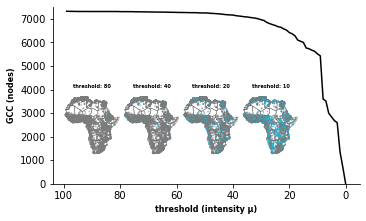

In [155]:
size = [0.15, 0.35]

selection = [80, 40, 20, 10]

(5.5, 6.5 / 2)

fig, ax = plt.subplots(figsize=(5.5, 6.5 / 2), facecolor='w')

ax.plot(np.arange(0, 100), lengths, color='k')

for i, j in zip(selection, [[0.15, 0.2], [0.3, 0.2], [0.45, 0.2], [0.6, 0.2], [0.75, 0.2]]):
    
    sub = plt.axes(j + size, facecolor='w')
    
    temp_comps = components[components['thrno']==i]
    print(temp_comps.shape)
    temp_comps = get_color(temp_comps)

    g = temp_comps.gcc.iloc[0]

    africa.plot(color='w', edgecolor='k', linewidth=0.5, alpha=0.5, ax=sub)

    temp_nodes = gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes['x'], nodes['y'], crs='epsg:4326'))
    temp_nodes = temp_nodes.merge(temp_comps, left_on='Agglomeration_ID', right_on='Agglomeration_ID')
    temp_nodes['component'] = temp_nodes['biggest_rank']
    
    temp_marks = np.sqrt(temp_nodes['Pop2015'] / 10**6)
    temp_nodes.sort_values('color').plot(color=temp_nodes['color'], markersize=0.5, alpha=0.5, ax=sub)
    sub.set_title(f"threshold: {i}", color='k', weight='bold', size = 5)
    # sub.set_title(f"threshold: {i} | GCC: {temp_comps.gcc.iloc[0]}", color='k', weight='bold', size = 5)
    sub.set_axis_off()
    

ax.invert_xaxis()
ax.set_ylim(0, 7.5 * 10**3)

ax.set_facecolor('w')

ax.spines["bottom"].set_color("k")
ax.spines["left"].set_color("k")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

font = {'weight':'bold', 'alpha':1.0, 'size':8}

ax.tick_params(axis='x', colors='k')
ax.tick_params(axis='y', colors='k')

mu = "intensity " + u"\u03BC"

ax.set_xlabel(f"threshold ({mu})", color="k", fontdict=font)
ax.set_ylabel("GCC (nodes)", color="k", fontdict=font)

# fig.suptitle('Size of Giant Connected Component', color='w', size=20, weight='bold')
fig.savefig('../viz/africapolis-gcc-risk-strip.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [27]:
components

,aggnm,pop15,thrno,thrid,comid,aggid,gcc,Agglomeration_ID,biggest_city,biggest_pop,biggest_rank,pop15count,pop15sum
716312,road,0,97,0000097,0000000,1087603,7320,1087603,Cairo,22995802,1.0,2135.0,455649790.0
721515,Akahufu,31100,98,0000098,0000000,0000395,7321,395,Cairo,22995802,1.0,2135.0,455649790.0
721517,road,0,98,0000098,0000000,1278349,7321,1278349,Cairo,22995802,1.0,2135.0,455649790.0
721518,road,0,98,0000098,0000000,1147277,7321,1147277,Cairo,22995802,1.0,2135.0,455649790.0
721519,Akatsi,39931,98,0000098,0000000,0000399,7321,399,Cairo,22995802,1.0,2135.0,455649790.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
728735,road,0,98,0000098,0000026,1055243,7321,1055243,road,0,2110.0,NaN,NaN
728738,road,0,98,0000098,0000029,1250541,7321,1250541,road,0,2110.0,NaN,NaN
736086,road,0,99,0000099,0000013,1109631,7325,1109631,road,0,2110.0,NaN,NaN
736089,road,0,99,0000099,0000016,1055367,7325,1055367,road,0,2110.0,NaN,NaN


In [33]:
from colorcet import palette
from matplotlib import colors
pal = np.tile(palette['glasbey_light'], len(components.comid.unique()) // len(palette['glasbey_light']))
pal = colors.ListedColormap(pal)

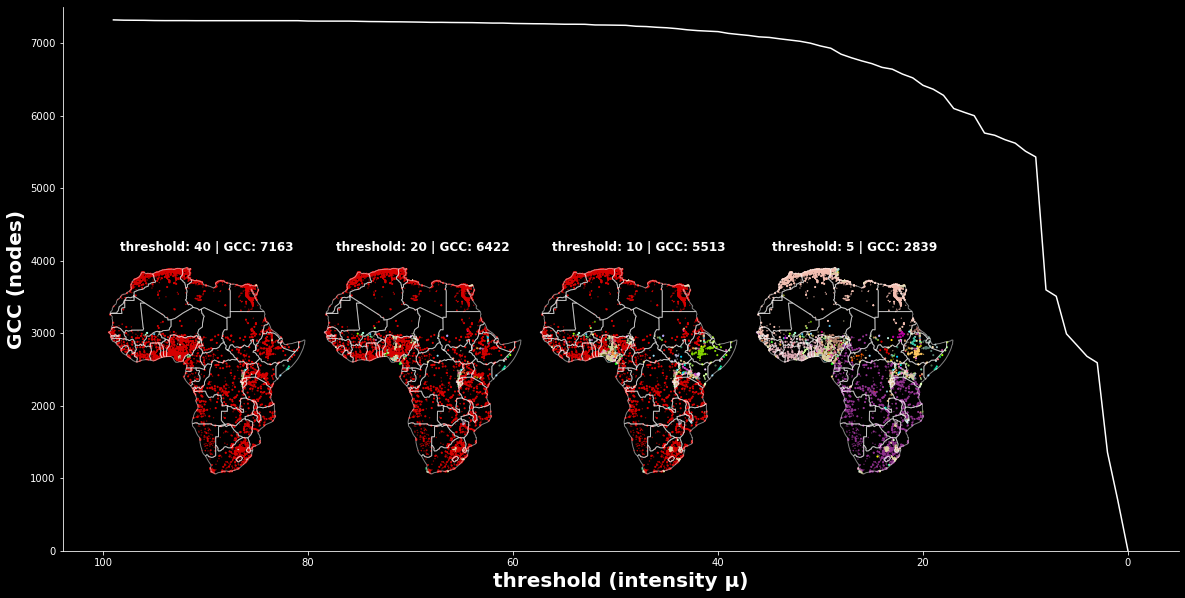

In [35]:
size = [0.15, 0.35]

selection = [40, 20, 10, 5]

(5.5, 6.5 / 2)

fig, ax = plt.subplots(figsize=(20, 10), facecolor='k')

ax.plot(np.arange(0, 100), lengths, color='w')

for i, j in zip(selection, [[0.15, 0.2], [0.3, 0.2], [0.45, 0.2], [0.6, 0.2], [0.75, 0.2]]):
    
    sub = plt.axes(j + size, facecolor='k')
    
    temp_comps = components[components['thrno']==i]

    g = temp_comps.gcc.iloc[0]

    temp_nodes = gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes['x'], nodes['y'], crs='epsg:4326'))
    temp_nodes = temp_nodes.merge(temp_comps, left_on='Agglomeration_ID', right_on='Agglomeration_ID')
    temp_nodes['component'] = temp_nodes['biggest_rank']
    temp_nodes = temp_nodes[temp_nodes['aggid']!='road']
    
    temp_marks= (np.log(temp_nodes['Pop2015'] + 1) + 1) / 10
    temp_nodes.plot('component', markersize=temp_marks, cmap=pal, ax=sub)
    
    africa.plot(color='None', edgecolor='w', linewidth=1, alpha=0.5, ax=sub)
    sub.set_title(f"threshold: {i} | GCC: {temp_comps.gcc.iloc[0]}", color='w', weight='bold')
    sub.set_axis_off()

ax.invert_xaxis()
ax.set_ylim(0, 7.5 * 10**3)

ax.set_facecolor('k')

ax.spines["bottom"].set_color("w")
ax.spines["left"].set_color("w")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

font = {'weight':'bold', 'alpha':1.0, 'size':20}

ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')

mu = "intensity " + u"\u03BC"

ax.set_xlabel(f"threshold ({mu})", color="w", fontdict=font)
ax.set_ylabel("GCC (nodes)", color="w", fontdict=font)

# fig.suptitle('Size of Giant Connected Component', color='w', size=20, weight='bold')
fig.savefig('../viz/africapolis-gcc-risk-components-strip.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')